In [1]:
import lightgbm as lgbm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
import numpy as np
import joblib


KeyboardInterrupt: 

In [ ]:
recipes_df = pd.read_parquet("~/resources/food/recipes.parquet")
user_df = pd.read_parquet("~/resources/food/user.parquet")
folder_df = pd.read_parquet("~/resources/food/folder.parquet")
bookmark_df = pd.read_parquet("~/resources/food/bookmark.parquet")


In [ ]:
keywords_df = pd.DataFrame.sparse.from_spmatrix(
    sparse.csr_array(
        pd.get_dummies(recipes_df["Keywords"].explode())
        .reset_index()
        .groupby("index")
        .sum()
        .values
    ),
    columns=np.unique(recipes_df["Keywords"].explode().dropna(how="any")),
)
keywords_df


,< 15 Mins,< 30 Mins,< 4 Hours,< 60 Mins,African,Apple,Artichoke,Asian,Australian,Austrian,...,Welsh,White Rice,Whitefish,Whole Chicken,Whole Duck,Whole Turkey,Wild Game,Winter,Yam/Sweet Potato,Yeast Breads
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522512,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
522513,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
522514,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
522515,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sparse.save_npz(
    "/home/amogus/resources/food/keywords_df.npz", keywords_df.sparse.to_coo()
)


In [ ]:
recipes_numerical = pd.merge(recipes_df[["RecipeId", "AggregatedRating", "ReviewCount"]].fillna(0.0), keywords_df, left_index=True, right_index=True)
# recipes_numerical = pd.merge(recipes_df[["RecipeId"]].fillna(0.0), keywords_df, left_index=True, right_index=True)
feature_columns = recipes_numerical.columns
feature_columns = feature_columns.delete(0)
recipes_numerical


,RecipeId,AggregatedRating,ReviewCount,< 15 Mins,< 30 Mins,< 4 Hours,< 60 Mins,African,Apple,Artichoke,...,Welsh,White Rice,Whitefish,Whole Chicken,Whole Duck,Whole Turkey,Wild Game,Winter,Yam/Sweet Potato,Yeast Breads
0,38.0,4.5,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39.0,3.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,40.0,4.5,10.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,41.0,4.5,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42.0,4.5,11.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522512,541379.0,0.0,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
522513,541380.0,0.0,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
522514,541381.0,0.0,0.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
522515,541382.0,0.0,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
folders_recipes_df = pd.merge(bookmark_df.sort_values(["folder_index", "rating"]), recipes_numerical, how="inner", left_on="RecipeId", right_on="RecipeId")
target_column = ["rating"]
folders_recipes_df[feature_columns]


,AggregatedRating,ReviewCount,< 15 Mins,< 30 Mins,< 4 Hours,< 60 Mins,African,Apple,Artichoke,Asian,...,Welsh,White Rice,Whitefish,Whole Chicken,Whole Duck,Whole Turkey,Wild Game,Winter,Yam/Sweet Potato,Yeast Breads
0,4.0,3.0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,5.0,318.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.5,252.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,1692.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5.0,347.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,5.0,3.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4.5,1657.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,5.0,3063.0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,5.0,1692.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,4.5,1657.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
groups = folders_recipes_df["folder_index"].value_counts().sort_index().to_list()
groups


[5, 4, 3, 1, 2, 4, 1, 1]

In [ ]:
ranker = lgbm.LGBMRanker(min_child_samples=1, num_leaves=63, learning_rate=0.01, n_estimators=1000, verbosity=-1)
ranker.fit(folders_recipes_df[feature_columns], folders_recipes_df[target_column], group=groups)


LGBMRanker(learning_rate=0.01, min_child_samples=1, n_estimators=1000,
           num_leaves=63, verbosity=-1)

Text(0.5, 1.0, 'feature importance')

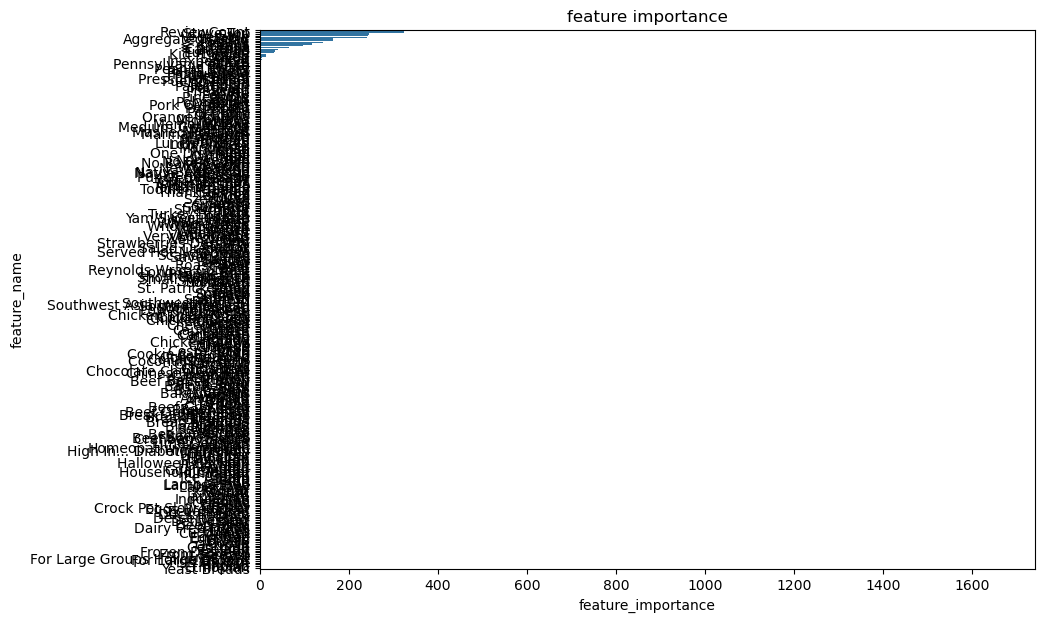

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': feature_columns, 'feature_importance':
ranker.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')


In [ ]:
def predict_from_folder_index(index: int):
    folder_keywords = np.unique(
        pd.merge(
            bookmark_df[bookmark_df["folder_index"] == index],
            recipes_df,
            how="inner",
            left_on="RecipeId",
            right_on="RecipeId",
        )["Keywords"].explode()
    )
    exclude_kw = list(set(keywords_df.columns).difference(folder_keywords))
    pred_df = recipes_numerical.copy()
    pred_df = pred_df.loc[pred_df[exclude_kw].values.sum(axis=1) == 0]
    preds = ranker.predict(pred_df[feature_columns])
    return recipes_df.iloc[
        pd.concat(
            [pred_df.reset_index(), pd.Series(preds).to_frame("rank_score")], axis=1
        )
        .sort_values("rank_score", ascending=False)
        .head(9)
        .sample(frac=1)
        .head(6)
        .set_index("index")
        .index
    ]


In [ ]:
def predict_from_user(user: str):
    folder_keywords = np.unique(
        pd.merge(
            bookmark_df[
                bookmark_df["folder_index"].isin(
                    folder_df[folder_df["username"] == user].index
                )
            ],
            recipes_df,
            how="inner",
            left_on="RecipeId",
            right_on="RecipeId",
        )["Keywords"].explode()
    )
    exclude_kw = list(set(keywords_df.columns).difference(folder_keywords))
    pred_df = recipes_numerical.copy()
    pred_df = pred_df.loc[pred_df[exclude_kw].values.sum(axis=1) == 0]
    preds = ranker.predict(pred_df[feature_columns])
    return recipes_df.iloc[
        pd.concat(
            [pred_df.reset_index(), pd.Series(preds).to_frame("rank_score")], axis=1
        )
        .sort_values("rank_score", ascending=False)
        .head(9)
        .sample(frac=1)
        .head(6)
        .set_index("index")
        .index
    ]


In [ ]:
def gen_recommendations(user: str):
    recommend_result = dict()
    if(not folder_df[folder_df["username"] == user].empty):
        recommend_result["recommend_from_summary"] = {
            "results": predict_from_user(user).fillna(np.nan).replace([np.nan], [None]).to_dict(orient="records")
        }
        for i, outt in enumerate(recommend_result["recommend_from_summary"]["results"]):
            for k, v in outt.items():
                if isinstance(v, np.ndarray):
                    recommend_result["recommend_from_summary"]["results"][i][k] = list(v)
        folder = folder_df[folder_df["username"] == user].sample(frac=1).head(1)
        recommend_result["recommend_from_folder"] = {
            "folder_name": folder.iloc[0]["folder_name"],
            "results": predict_from_folder_index(folder.index[0]).fillna(np.nan).replace([np.nan], [None]).to_dict(orient="records")
        }
        for i, outt in enumerate(recommend_result["recommend_from_folder"]["results"]):
            for k, v in outt.items():
                if isinstance(v, np.ndarray):
                    recommend_result["recommend_from_folder"]["results"][i][k] = list(v)
        recommend_result["recommend_from_random"] = {
            "results": recipes_df.sample(6).fillna(np.nan).replace([np.nan], [None]).to_dict(orient="records")
        }
        for i, outt in enumerate(recommend_result["recommend_from_random"]["results"]):
            for k, v in outt.items():
                if isinstance(v, np.ndarray):
                    recommend_result["recommend_from_random"]["results"][i][k] = list(v)
    return recommend_result


In [ ]:
user = "test5"
recommend_result = dict()
if not folder_df[folder_df["username"] == user].empty:
    if pd.merge(
        folder_df[folder_df["username"] == user],
        bookmark_df,
        left_index=True,
        right_on="folder_index",
        how="inner",
    ).empty:
        recommend_result["recommend_from_summary"] = {"results": []}
    else:
        recommend_result["recommend_from_summary"] = {
            "results": predict_from_user(user)
            .fillna(np.nan)
            .replace([np.nan], [None])
            .to_dict(orient="records")
        }
        for i, outt in enumerate(recommend_result["recommend_from_summary"]["results"]):
            for k, v in outt.items():
                if isinstance(v, np.ndarray):
                    recommend_result["recommend_from_summary"]["results"][i][k] = list(
                        v
                    )
    folder = folder_df[folder_df["username"] == user].sample(frac=1).head(1)
    if pd.merge(
        folder, bookmark_df, left_index=True, right_on="folder_index", how="inner"
    ).empty:
        recommend_result["recommend_from_folder"] = {
            "folder_name": folder.iloc[0]["folder_name"],
            "results": [],
        }
    else:
        recommend_result["recommend_from_folder"] = {
            "folder_name": folder.iloc[0]["folder_name"],
            "results": predict_from_folder_index(folder.index[0])
            .fillna(np.nan)
            .replace([np.nan], [None])
            .to_dict(orient="records"),
        }
        for i, outt in enumerate(recommend_result["recommend_from_folder"]["results"]):
            for k, v in outt.items():
                if isinstance(v, np.ndarray):
                    recommend_result["recommend_from_folder"]["results"][i][k] = list(v)
    recommend_result["recommend_from_random"] = {
        "results": recipes_df.sample(6)
        .fillna(np.nan)
        .replace([np.nan], [None])
        .to_dict(orient="records")
    }
    for i, outt in enumerate(recommend_result["recommend_from_random"]["results"]):
        for k, v in outt.items():
            if isinstance(v, np.ndarray):
                recommend_result["recommend_from_random"]["results"][i][k] = list(v)


Empty DataFrame
Columns: [username, folder_name, folder_index, RecipeId, rating]
Index: []


In [ ]:
out = predict_from_folder_index(5)
out


,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
10012,13187.0,Beef Barley Veggy Soup - Crock Pot,5060,Derf2440,PT9H,PT20M,PT9H20M,2001-10-24 11:00:00+00:00,Make and share this Beef Barley Veggy Soup - C...,[https://img.sndimg.com/food/image/upload/w_55...,...,1.4,43.5,721.9,19.4,4.1,2.9,19.0,NaN,None,[Mix all ingredients in 4-5 quart crock pot sl...
30657,34273.0,Crock Pot Teriyaki Wingers,23302,Millereg,PT6H,PT20M,PT6H20M,2002-07-15 23:05:00+00:00,Make and share this Crock Pot Teriyaki Wingers...,[],...,15.3,262.2,2400.2,65.9,1.2,56.2,66.3,4.0,None,"[Rinse the wings and pat them dry., Cut off an..."
52964,57130.0,Awesome Slow Cooker Pot Roast,63475,Kaccy G.,PT8H,PT10M,PT8H10M,2003-03-25 20:08:00+00:00,I found this on the all recipes site. This is ...,[https://img.sndimg.com/food/image/upload/w_55...,...,0.7,0.0,546.6,5.0,0.2,0.8,1.0,12.0,None,"[In a slow cooker, mix cream of mushroom soup,..."
7603,10733.0,Broccoli Salad,13924,vincy bramblett,None,PT30M,PT30M,2001-08-07 08:33:00+00:00,This is always a HIT with guests. I make this ...,[https://img.sndimg.com/food/image/upload/w_55...,...,8.5,43.5,591.6,19.4,1.3,11.3,9.2,NaN,None,[Cook bacon (I make it easy and buy the alread...
16526,19859.0,Crock Pot Creamy Italian Chicken,23302,Millereg,PT4H,PT5M,PT4H5M,2002-02-16 11:28:00+00:00,Make and share this Crock Pot Creamy Italian C...,[https://img.sndimg.com/food/image/upload/w_55...,...,11.7,138.0,603.4,5.7,1.6,3.4,29.7,NaN,None,[Place the chicken breast halves in the crock ...
9300,12458.0,Crock Pot Cream Cheese Chicken,18660,Dawn399,PT7H,PT20M,PT7H20M,2001-10-06 09:00:00+00:00,I got this recipe from a nurse at work. We're ...,[https://img.sndimg.com/food/image/upload/w_55...,...,19.0,169.5,696.8,6.4,0.2,2.0,29.8,6.0,None,[Place chicken pieces in crock pot and sprinkl...
